In [45]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [2]:
data = np.load('/u/scr/ethanchi/embeddings/temporal2/representations.npy')
print(data.shape)

(20000, 30, 768)


In [3]:
labels = pd.read_csv('/u/scr/ethanchi/embeddings/temporal2/sentences-cut.txt', sep="\t")
print(labels.columns)
print(labels.shape)

Index(['sentence', 'noun1', 'noun1_idx', 'verb1', 'verb1_idx', 'connector1',
       'connector1_idx', 'connector1_char', 'noun2', 'noun2_idx', 'verb2',
       'verb2_idx', 'connector2', 'connector2_idx', 'connector2_char', 'noun3',
       'noun3_idx', 'verb3', 'verb3_idx'],
      dtype='object')
(20000, 19)


In [4]:
# we train a direction vector
verb1_indices = labels['verb1_idx'].astype('int32').values
print(verb1_indices)
verb2_indices = labels['verb2_idx'].astype('int32').values
verb3_indices = labels['verb3_idx'].astype('int32').values

verb1_verb2_directions = np.where(labels['connector1_char'] == 'past', 1, -1)
verb2_verb3_directions = np.where(labels['connector2_char'] == 'past', 1, -1)

print(verb1_verb2_directions, verb2_verb3_directions)

[2 2 2 ... 2 2 2]
[-1  1 -1 ... -1  1  1] [ 1 -1  1 ...  1 -1 -1]


In [5]:
verb1_embeddings = data[np.arange(data.shape[0]), list(verb1_indices), :]
verb2_embeddings = data[np.arange(data.shape[0]), list(verb2_indices), :]

print(verb1_embeddings.shape, verb2_embeddings.shape)

(20000, 768) (20000, 768)


In [28]:
data_raw = (verb1_embeddings - verb2_embeddings) * verb1_verb2_directions[:, np.newaxis]
indices = np.arange(data_raw.shape[0])
np.random.shuffle(indices)
data_raw = data_raw[indices]


sep = int(indices.shape[0] * .9)

train_set_raw = data_raw[:sep]
test_set_raw = data_raw[sep:]

train_labels = labels.iloc[indices][:sep]
test_labels = labels.iloc[indices][sep:]

directions = verb1_verb2_directions[indices]
train_directions = directions[:sep]
test_directions = directions[sep:]

# train_set_raw = 
# test_set_raw = 

train_set = train_set_raw / np.linalg.norm(train_set_raw, axis=1, keepdims=True)
test_set = test_set_raw / np.linalg.norm(test_set_raw, axis=1, keepdims=True)

In [29]:
input_size = data.shape[-1]

class DirectionProbe(nn.Module):
    def __init__(self, inputSize):
        super(DirectionProbe, self).__init__()
        self.inputSize = inputSize
        self.u = nn.Parameter(data = torch.zeros(self.inputSize))
        nn.init.uniform_(self.u, -0.05, 0.05)
    def forward(self, batch):
        return torch.mean(batch @ (self.u / torch.norm(self.u)))

train_inputs = torch.Tensor(train_set)
test_inputs = torch.Tensor(test_set)
model = DirectionProbe(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

NUM_EPOCHS = 2000

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    output = model(train_inputs)
    error = 1 - output
    error.backward()
    optimizer.step()
    if epoch % 100 == 0:
        test_output = model(test_inputs)
        print("Epoch {}, train score {}, test score {}".format(epoch, output, test_output))


Epoch 0, train score -0.0015861870488151908, test score -0.0019032120471820235
Epoch 100, train score 0.019080784171819687, test score 0.018854115158319473
Epoch 200, train score 0.03772050887346268, test score 0.03752101585268974
Epoch 300, train score 0.05255352705717087, test score 0.052303608506917953
Epoch 400, train score 0.06277395039796829, test score 0.06242715194821358
Epoch 500, train score 0.06894014775753021, test score 0.06853000819683075
Epoch 600, train score 0.07228364050388336, test score 0.07186432182788849
Epoch 700, train score 0.07393142580986023, test score 0.07353299111127853
Epoch 800, train score 0.0746815949678421, test score 0.07431016862392426
Epoch 900, train score 0.07500523328781128, test score 0.07465513050556183
Epoch 1000, train score 0.07514021545648575, test score 0.0748034343123436
Epoch 1100, train score 0.07519490271806717, test score 0.07486546039581299
Epoch 1200, train score 0.07521636039018631, test score 0.07489080727100372
Epoch 1300, train

In [59]:
EPSILON = 0.0001
direction_vector = model.u.cpu().detach().numpy()
direction_vector /= np.linalg.norm(direction_vector)
numSuccessful = len(np.where(np.linalg.norm(train_set_raw, axis=1) > np.linalg.norm(train_set_raw - EPSILON * direction_vector, axis=1))[0])
print(numSuccessful / train_set_raw.shape[0])

0.7508888888888889


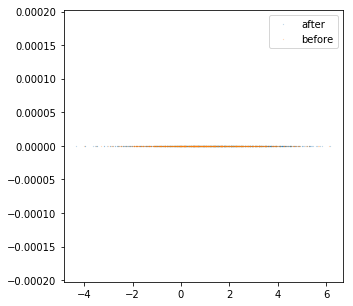

In [38]:
plt.figure(figsize=(5, 5))

before = test_set_raw[test_directions == -1] @ direction_vector
after = test_set_raw[test_directions == 1] @ direction_vector

plt.scatter(after, np.zeros(after.shape[0]), label="after", s=0.01)
plt.scatter(before, np.zeros(before.shape[0]), label="before", s=0.01)


plt.legend()

plt.show()

after 0.7991967871485943
until 0.9076923076923077
earlier than 0.424
then 0.9543568464730291
before 0.7601809954751131
subsequently to 0.9613899613899614
later than 0.6150793650793651
(2000, 19)


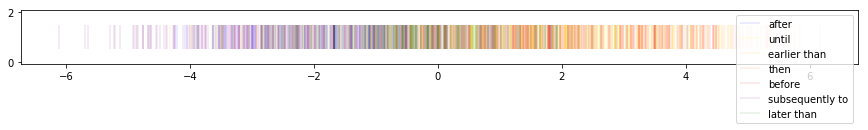

In [53]:
to_plot_data = (verb1_embeddings - verb2_embeddings)[indices][sep:]

plt.figure(figsize=(15, 1))

test_directions = verb1_verb2_directions[sep:]


# colors=['blue', 'red', 'green', 'orange', 'yellow', 'orangered', 'purple']

# for idx, word in enumerate(('after', 'before', 'later than', 'earlier than', 'until', 'then', 'subsequently to')):
# colors=['blue', 'red', 'green', 'orange']

# for idx, word in enumerate(('after', 'before', 'later than', 'earlier than')):
colors = ('blue', 'red', 'green', 'orange', 'yellow', 'orangered', 'purple')
words = ('after', 'before', 'later than', 'earlier than', 'until', 'then', 'subsequently to')

for color, word in random.sample(list(zip(colors, words)), len(colors)):
  arr = to_plot_data[test_labels['connector1'] == word] @ direction_vector
  plt.eventplot(arr, orientation='horizontal', label=word, colors=color, alpha=0.1)
  print(word, len(np.where(np.linalg.norm(test_set[test_labels['connector1'] == word] + EPSILON * direction_vector, axis=1) > np.linalg.norm(test_set[test_labels['connector1'] == word], axis=1))[0]) /
       len(test_set[test_labels['connector1'] == word]))


print(test_labels.shape)

plt.legend(markerscale=2)

plt.show()